In [95]:
import numpy as np
from sklearn.base import BaseEstimator
from scipy.stats import bernoulli
from collections import Counter

Consider a `SporadicClassifier` that returns a random label in {`True`, `False`} for any test input that’s fed to it. This classifier does not require any training! Hope, that was already obvious to you. Implement this `SporadicClassifier` as a Python class by extending the `BaseEstimator` class of sklearn, so that you have mandatory methods such as `fit(X, y)` and `predict(X)` are implemented. As your guess, the `fit()` method would be a dummy ‘pass’, but the `predict()` method would return `True` or `False` randomly.

In [54]:
class SporadicClassifier(BaseEstimator):
    def __init__(self, p=0.5, method='uniform_random'):
        self.p = 0.5 if p < 0.0 or p > 1.0 else p
        self.method = method if method in ["uniform_random", "bernoulli", "normal"] else "uniform_random"
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        # we center the normal distribution at 0.5 instead of 0.0
        if self.method == "gaussian":
            return (0.5 + np.random.randn(len(X))) < self.p
        elif self.method == "bernoulli":
            return np.bool_(bernoulli.rvs(self.p, size=len(X)))
        else:
            return np.random.rand(len(X)) < self.p

__it does not matter what the dataset is, as the classifier is not depending on the inputs__

In [146]:
# let's create a dataset of size 100 instances.
X = np.random.rand(100)

__let's compute the label distribution for different configuration of the classifier__

In [147]:
cla = SporadicClassifier(p=0.3, method='gaussian')
y = cla.predict(X)
c = Counter(y) 
{i[0]: i[1] / len(y) for i in c.items()}

{False: 0.74, True: 0.26}

__create reusable functions__

In [148]:
def compute_prior(y):
    # initialize the counter object on the 'y' labels
    c = Counter(y)
    # convert the labels into class proportions
    props = {i[0]:i[1]/len(y) for i in c.items()}
    if True not in props:
        props[True] = 0.0
    if False not in props:
        props[False] = 0.0
    return props

__extract the probability of True predictions for the dataset using different random generators__

In [149]:
p_vals = np.arange(0., 1., 0.1)
b_vals = []
g_vals = []
u_vals = []
for p in p_vals:
    cla = SporadicClassifier(p=p, method='bernoulli')
    y = cla.predict(X)
    props = compute_prior(y)
    b_vals.append(props[True])
    
    y = SporadicClassifier(p=p, method='gaussian').predict(X)
    props = compute_prior(y)
    g_vals.append(props[True])
    
    y = SporadicClassifier(p=p, method='uniform_random').predict(X)
    props = compute_prior(y)
    u_vals.append(props[True])

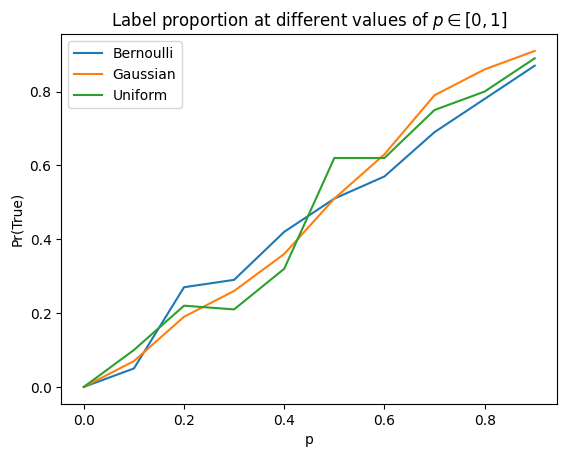

In [150]:
import matplotlib.pyplot as plt
plt.plot(p_vals, b_vals)
plt.plot(p_vals, g_vals)
plt.plot(p_vals, u_vals)
plt.xlabel('p')
plt.ylabel('Pr(True)')
plt.title('Label proportion at different values of $p\in[0,1]$')
plt.legend(['Bernoulli','Gaussian','Uniform'], loc='upper left')
plt.show()

__if the number of samples is increased, the plots tend to understandably become a straight line__